# Real-time Interactive Transit Dashboard

This notebook uses stream processing methods in [csp](https://github.com/Point72/csp) to monitor real-time metrics on four different transportation methods in New York City. Each monitoring pipeline is constructed as a "subgraph" and then all metrics are combined together in the final interactive dashboard graph. This an example of **composable** stream processing (csp!).

1. **Subway**: The New York City Subway is the second busiest metro system outside of Asia with over 2 billion annual riders [[1](https://en.wikipedia.org/wiki/List_of_metro_systems)]. The Metropolitan Transportation Authority (MTA), who run the subway system, expose a public API with real-time data on train positions and stop times. The data is exposed in a bespoke GTFS (General Transit Feed Specification) data format ([reference guide](https://new.mta.info/document/134521)), which is a transit-specific form of *protobuf*. There are [8 API endpoints](https://api.mta.info/#/subwayRealTimeFeeds) for different groups of lines. Each endpoint updates every 30 seconds. For the sake of this example, we will only use the main feed which covers 7 major train lines. We will calculate the average wait time for a train across *all* stations on these lines, and use it as an apprpriate estimate for system-wide delay. We will also calculate the 90th and 99th percentile wait times, since you can always be unlucky! 

       
2. **Bus**: The MTA reports [active bus alerts](https://api.mta.info/#/serviceAlerts) in a live feed. The feed is exposed in both JSON and GTFS formats; we will use the JSON endpoint. Like all MTA feeds, the data updates every 30 seconds. We will display the total number of bus alerts as well as a breakdown of alerts by whether they are planned or unplanned. 

    
3. **Commuter rail**: We will use the same MTA alerting data for commuter rail lines. There are two commuter rail providers ([Metro North](https://new.mta.info/agency/metro-north-railroad) and the [Long Island Rail Road](https://new.mta.info/agency/long-island-rail-road)) owned by the MTA. We will monitor the Long Island Railroad in this example. The features are the same as those calculated for the bus data above. 


4. **Bikeshare**: New York City uses a bikeshare system called CitiBike, now owned by Lyft. CitiBike provides live station status data which includes the number of bikes available and the number of open docks for returning a bike. They use the GBFS ([General Bikeshare Feed Specification](https://github.com/MobilityData/gbfs/blob/master/gbfs.md)) format for their data, which is provided in JSON at their [API endpoint](https://gbfs.lyft.com/gbfs/2.3/bkn/en/station_status.json). To monitor the status of bikesharing, we will keep track of the number of stations with no bikes available (*empty stations*) and the number of stations with no docks available (*full stations*). If there are many stations with these conditions, then it will be hard to find a bike and return it after the ride.


All of these data feeds will be polled asynchronously to demonstrate the power of the *csp* engine.


## Requirements

This notebook requires the following packages to be installed: `pip install csp requests pandas graphviz tzlocal perspective`

We also use local files and historical data from the `csp_mta` library, which are stored in the repository with this notebook. 

## Getting the Input Data

Our first step is to set up *input adapters* for each live data feed. Users can create their own *csp* adapters for any data format, so we'll create adapters for JSON and GTFS inputs. Note that the code here is imported from the collection of [csp-community](https://github.com/csp-community/) projects on GitHub. We'll import in the GTFSRealtimeInputAdapter and JSONRealtimeInputAdapter, but I invite you to take a look at their implementation in `demo/csp_mta/GTFSInputAdapter.py` and `demo/csp_mta/JSONInputAdapter.py`. Adapters can also be implemented in C++ if low-latency is required.

In [1]:
# GTFS input adapter for subway data
# JSON input adapter for alerts and bike info
# csp_mta is included with this notebook (see community project on GitHub)

import csp
from csp_mta import GTFSRealtimeInputAdapter
from csp_mta import JSONRealtimeInputAdapter

In [2]:
JSONRealtimeInputAdapter

csp.impl.wiring.adapters.JSONRealtimeAdapter

## Monitoring subway status

The first subgraph we'll create will monitor subway wait times and out-of-service stations. Each GTFS message from the MTA feed contains a list of trips, each with a list of future stops. We can use this data to find the next train stopping at each station.

In [3]:
from csp_mta import STOP_INFO_DF

STOP_INFO_DF.head(10) # mapping of stops to their ID and location

,stop_name,stop_lat,stop_lon,location_type,parent_station
stop_id,,,,,
101,Van Cortlandt Park-242 St,40.889248,-73.898583,1.0,NaN
101N,Van Cortlandt Park-242 St,40.889248,-73.898583,NaN,101
101S,Van Cortlandt Park-242 St,40.889248,-73.898583,NaN,101
103,238 St,40.884667,-73.900870,1.0,NaN
103N,238 St,40.884667,-73.900870,NaN,103
103S,238 St,40.884667,-73.900870,NaN,103
104,231 St,40.878856,-73.904834,1.0,NaN
104N,231 St,40.878856,-73.904834,NaN,104
104S,231 St,40.878856,-73.904834,NaN,104


In [4]:
all_bidrectional_stops = STOP_INFO_DF[STOP_INFO_DF['location_type'] != 1.0].index
all_bidrectional_stops

# includes subway plus Staten Island Railroad
# many stations are also double counted if they are transfer stops

Index(['101N', '101S', '103N', '103S', '104N', '104S', '106N', '106S', '107N',
       '107S',
       ...
       'S27N', 'S27S', 'S28N', 'S28S', 'S29N', 'S29S', 'S30N', 'S30S', 'S31N',
       'S31S'],
      dtype='object', name='stop_id', length=998)

In [5]:
# we are only going to use the numbered lines in the system
as_list = list(all_bidrectional_stops)
all_1to7_stops = [x for x in as_list if x[0] in '12345679']

Next, we'll write the node to compute various wait time statistics. We will compute the average across all stops as well as the 90th and 99th percentiles. `WaitTimeData` is a `csp.Struct`, a built-in dataclass where each member can also be accessed as an individual time-series. 

In [6]:
import pytz
import typing
import numpy as np
from datetime import datetime
from tzlocal import get_localzone

from csp_mta.compiled_protobuf.gtfs_realtime_pb2 import FeedMessage

max_date = pytz.timezone('US/Eastern').localize(
    datetime(2040, 12, 31, 23, 59, 59, 999999)
)

class WaitTimeData(csp.Struct):
    avg: float
    p90: float
    p99: float
    valid: int
    invalid: int
    
@csp.node
def wait_time_stats(
    gtfs_msgs: csp.ts[FeedMessage], stop_ids: typing.List[str]
) -> csp.ts[WaitTimeData]:
    """
    Find the average, 90th percentile and 99th percentile wait times across the system.
    Returns all values in minutes.
    """
    next_train = { stop_id: max_date for stop_id in stop_ids }
    now = pytz.timezone('UTC').localize(csp.now())
    for entity in gtfs_msgs.entity:
        if entity.HasField("trip_update"):
            stop_time_updates = entity.trip_update.stop_time_update
            for update in stop_time_updates:
                stop_time = datetime.fromtimestamp(update.arrival.time, tz=get_localzone())
                if stop_time >= now:
                    next_train[update.stop_id] = min(next_train[update.stop_id], stop_time)
    
    valid_vals = []
    for stop, t in next_train.items():
        if t < max_date:
            valid_vals.append((t - now).total_seconds())
    
    # Write out outputs
    wtd = WaitTimeData(
        avg=sum(valid_vals)/len(valid_vals)/60, # convert to minutes
        p90=np.quantile(valid_vals, 0.9)/60,
        p99=np.quantile(valid_vals, 0.99)/60,
        valid=len(valid_vals),
        invalid=len(next_train)-len(valid_vals)
    )
    return wtd

We can also run our wait time calculator on historical data. Unfortunately, the MTA does not provide historical data files, so we recorded a days worth of data manually by writing the raw message bytes to a Parquet file. We load this data back into the graph using the builtin ParquetReader in *csp* and convert the messages to GTFS format with a custom node.

In [7]:
# Let's run this basic subgraph on historical data and realtime data

from csp.adapters.parquet import ParquetReader
from csp_mta.compiled_protobuf.gtfs_realtime_pb2 import FeedMessage
from csp import ts

@csp.node
def raw_bytes_to_gtfs_message(raw: csp.ts[str]) -> csp.ts[FeedMessage]:
    feed = FeedMessage()
    feed.ParseFromString(raw.encode("latin-1"))
    return feed


@csp.graph
def nyc_subway_wait_time_graph(realtime: bool) -> ts[WaitTimeData]:
    if realtime:
        gtfs = GTFSRealtimeInputAdapter('1234567S', False) # only use a subset of the lines for this example
    else:
        raw_bytes = ParquetReader(
            filename_or_list=[
                "recorded_subway_data1.parquet",
                "recorded_subway_data2.parquet"
            ], time_column="time"
        ).subscribe_all(typ=str, field_map="msg")
        gtfs = raw_bytes_to_gtfs_message(raw_bytes)
    
    stats = wait_time_stats(gtfs, all_1to7_stops)
    return stats

Let's take a look at our graph before we run it. We can do this using `csp.showgraph`.

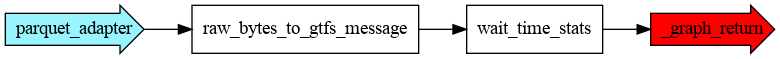

In [8]:
from PIL import Image

buffer = csp.showgraph.generate_graph(nyc_subway_wait_time_graph, False)
image = Image.open(buffer)
display(image)

In [9]:
# Realtime
from datetime import timedelta

csp.run(nyc_subway_wait_time_graph, True, starttime=datetime.utcnow(), endtime=timedelta(seconds=1), realtime=True)

{0: [(datetime.datetime(2024, 6, 14, 18, 21, 23, 938883),
   WaitTimeData( avg=4.6699960011307935, p90=8.461018616666665, p99=55.36601861666691, valid=339, invalid=19 ))]}

In [10]:
# Historical (ran before presentation, as its processing 18 hours of data)
EST = pytz.timezone('US/Eastern')

start = EST.localize(datetime(2024,4,23,7,30))
end = EST.localize(datetime(2024,4,24,7,30))

res_subway = csp.run(nyc_subway_wait_time_graph, False, starttime=start, endtime=end, realtime=False, output_numpy=True)

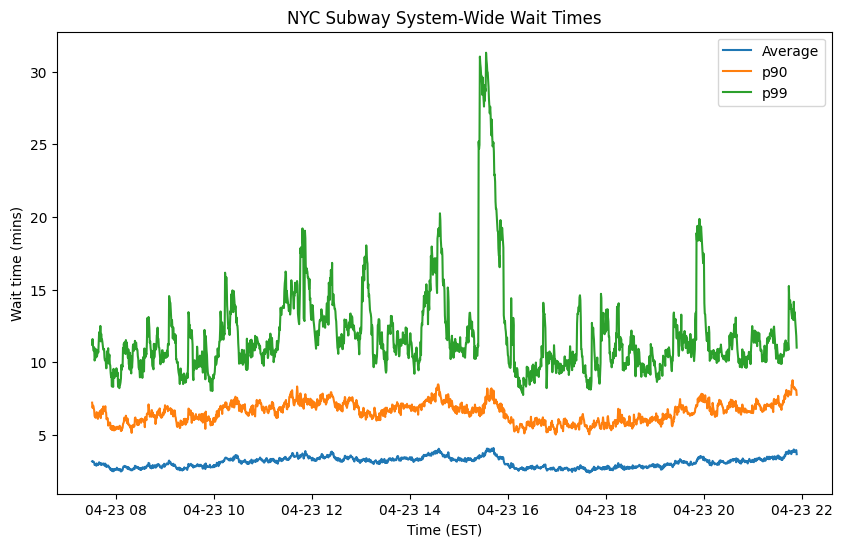

In [11]:
# Let's plot our results
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd 

times = res_subway[0][0]
values = res_subway[0][1]

# Convert the values to minutes
avg = [v.avg for v in values]
p90 = [v.p90 for v in values]
p99 = [v.p99 for v in values]

# csp default time is UTC - convert to NYC local time
times_in_est = pd.DatetimeIndex(times).tz_localize(
    pytz.timezone('UTC')).tz_convert(
        'US/Eastern'
    )

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(times_in_est, avg, label='Average')
plt.plot(times, p90, label='p90')
plt.plot(times, p99, label='p99')
plt.legend()
plt.ylabel('Wait time (mins)')
plt.xlabel('Time (EST)')
plt.title('NYC Subway System-Wide Wait Times')

# Display the plot
plt.show()

## Bus and commuter rail alerts

Next, we will create the subgraph to track active bus and commuter rail (LIRR) alerts. These two will actually be the same "graph" but with different arguments. We will subscribe to the JSON alert feeds using the `JSONRealtimeInputAdapter` and then use a `csp.node` to count the number of delays of each type. Afterwards, we'll use another node to break them down between planned and unplanned.

In [12]:
from csp_mta import ALERT_ENDPOINTS, MTA_FEED_UPDATE_TIME
from typing import Dict

@csp.node
def get_alert_type(alerts: csp.ts[dict]) -> csp.ts[Dict[str, int]]:
    """
    Creates a dictionary with the counts of each alert type
    """
    cnts = {}
    for alert in alerts['entity']:
        atype = alert['alert']['transit_realtime.mercury_alert']['alert_type']
        if atype in cnts:
            cnts[atype] += 1
        else:
            cnts[atype] = 1
    return cnts

@csp.graph
def transit_alert_graph(endpoint: str) -> csp.ts[Dict[str, int]]:
    alerts = JSONRealtimeInputAdapter(endpoint, MTA_FEED_UPDATE_TIME, False)
    count_by_type = get_alert_type(alerts)
    return count_by_type

In [13]:
# How's the bus doing today?
res_bus = csp.run(transit_alert_graph, ALERT_ENDPOINTS['bus'], realtime=True,
              starttime=datetime.utcnow(), endtime=timedelta(seconds=1), output_numpy=True)
res_bus

{0: (array(['2024-06-14T18:23:17.596754496'], dtype='datetime64[ns]'),
  array([{'Delays': 3, 'Detour': 3, 'Boarding Change': 69, 'Planned - Detour': 39, 'Expect Delays': 14, 'Planned - Stops Skipped': 4, 'Planned - Part Suspended': 4, 'Saturday Schedule': 1, 'Station Notice': 1}],
        dtype=object))}

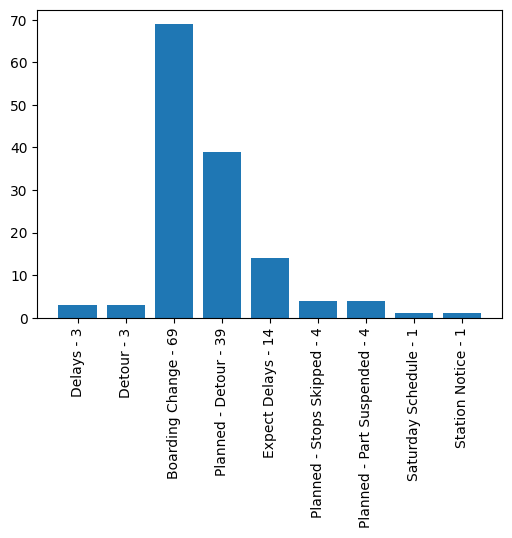

In [14]:
%matplotlib inline

import matplotlib.pyplot as plt

cnts = res_bus[0][1][0]
labels = [f'{k} - {v}' for k, v in cnts.items()]
plt.figure(figsize=(6, 4))
plt.bar(range(len(labels)), cnts.values(), tick_label=labels)
plt.xticks(rotation='vertical')
plt.show()

We can break these alerts into two categories - Planned and Unplanned. Let's add a node that filters between the two alert types. We'll also use a `csp.Struct` to store our final return value, which will be the total number of alerts and its breakdown by planned/unplanned types.

In [15]:
class AlertInfo(csp.Struct):
    total_alerts: int
    planned_alerts: int
    unplanned_alerts: int

@csp.node
def count_planned_unplanned(alert_types: ts[Dict[str, int]]) -> csp.ts[AlertInfo]:
    p, up = 0, 0
    for key, val in alert_types.items():
        if 'Planned' in key:
            p += val
        else:
            up += val
    return AlertInfo(
        total_alerts=p+up,
        planned_alerts=p,
        unplanned_alerts=up
    )

# We can use our prior "transit_alert_graph" as a subgraph here
@csp.graph
def alert_breakdown_graph(endpoint: str) -> ts[AlertInfo]:
    all_alert_counts = transit_alert_graph(endpoint)
    return count_planned_unplanned(all_alert_counts)

In [16]:
# Let's test our alert breakdown

csp.run(alert_breakdown_graph, ALERT_ENDPOINTS['bus'], starttime=datetime.utcnow(), endtime=timedelta(seconds=1), realtime=True)

{0: [(datetime.datetime(2024, 6, 14, 18, 23, 24, 657921),
   AlertInfo( total_alerts=138, planned_alerts=47, unplanned_alerts=91 ))]}

### Commuter rail alerts

Since the MTA uses the same alert format for all its transportation methods, we can use the same graph on commuter rail data! Let's take a look at what current alerts New York City's main commuter line is reporting.

In [17]:
# Let's check LIRR
csp.run(transit_alert_graph, ALERT_ENDPOINTS['lirr'], starttime=datetime.utcnow(), endtime=timedelta(seconds=1), realtime=True)

{0: [(datetime.datetime(2024, 6, 14, 18, 23, 27, 307351),
   {'Some Delays': 1,
    'Planned - Stops Skipped': 4,
    'Extra Service': 1,
    'Weekday Schedule': 1,
    'Planned - Substitute Buses': 1})]}

## Bikeshare availability

Lastly, we will connect to the CitBike data feed and monitor the number of stations with either no bikes or no docks available. We will also track the total number of bikes available across all of New York City. The CitiBike data uses the GBFS data format mentioned in the introduction, which has an underlying JSON representation. Thus, we can use the JSONRealtimeInputAdapter to get the data into our graph, and as above use a series of nodes to extract features.

The realtime data is updated every 60 seconds.

In [18]:
import pandas as pd
import requests

CITI_BIKE_STATION_ENDPOINT = "https://gbfs.lyft.com/gbfs/2.3/bkn/en/station_status.json"

# Let's look at the data first

record = requests.get(CITI_BIKE_STATION_ENDPOINT).json()["data"]["stations"]
pd.json_normalize(record)

,num_docks_disabled,is_returning,num_bikes_disabled,is_installed,is_renting,num_bikes_available,station_id,num_ebikes_available,vehicle_types_available,last_reported,num_docks_available,num_scooters_unavailable,num_scooters_available
0,0,0,0,0,0,0,c1a4d909-0a00-475a-8e82-18ed13a4eb01,0,"[{'count': 0, 'vehicle_type_id': '1'}, {'count...",1717071330,0,NaN,NaN
1,0,0,0,0,0,0,40043e8a-6ef6-428d-b585-a7c23cdb06d4,0,"[{'count': 0, 'vehicle_type_id': '1'}, {'count...",1717166623,0,NaN,NaN
2,0,0,0,0,0,0,7d5fa1f0-4069-4d5d-b735-5d500597394a,0,"[{'count': 0, 'vehicle_type_id': '1'}, {'count...",1717172562,0,NaN,NaN
3,0,0,2,1,0,0,bcb08532-f0d5-4c0e-ad8a-4ddacc204791,0,"[{'count': 0, 'vehicle_type_id': '1'}, {'count...",1718385365,16,0.0,0.0
4,0,1,1,1,1,19,1817822909864556798,13,"[{'count': 6, 'vehicle_type_id': '1'}, {'count...",1718389151,6,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2207,0,1,0,1,1,30,581211b2-4e42-48f2-8a8f-5f968cb1c5df,25,"[{'count': 5, 'vehicle_type_id': '1'}, {'count...",1718389257,3,0.0,0.0
2208,0,1,2,1,1,3,66ddd93e-0aca-11e7-82f6-3863bb44ef7c,1,"[{'count': 2, 'vehicle_type_id': '1'}, {'count...",1718389258,9,0.0,0.0
2209,0,1,0,1,1,24,bd6f422b-d7ae-4d7e-9261-653fdd8e6888,8,"[{'count': 16, 'vehicle_type_id': '1'}, {'coun...",1718389263,4,0.0,0.0
2210,0,1,3,1,1,3,b6a13f2b-deb4-4f4d-9d67-7d23bee27c88,2,"[{'count': 1, 'vehicle_type_id': '1'}, {'count...",1718389261,9,0.0,0.0


There are some stations with no bikes available but also no docks available. These stations are yet to be installed, so their "is_installed" field is 0. We will filter these out with a csp node.

In [19]:
import pandas as pd
import numpy as np

@csp.node
def remove_inactive_stations(df: csp.ts[pd.DataFrame]) -> csp.ts[pd.DataFrame]:
    return df[df['is_installed'] == 1]

We'll compute some statistics of the data, including the total number of bikes/docks available across the system and the number of stations with no bikes/docks available. The stats will be returned in a `csp.Struct` as we did before.

In [20]:
@csp.node
def json_to_station_df(data: csp.ts[dict]) -> csp.ts[pd.DataFrame]:
    return pd.json_normalize(data["data"]["stations"])

@csp.node
def count_stations_with_zero_condition(df: csp.ts[pd.DataFrame], field: str) -> csp.ts[int]:
    return int((df[field] == 0).sum())

@csp.node
def column_summation(df: csp.ts[pd.DataFrame], field: str) -> csp.ts[int]:
    return int(df[field].sum())

class StationStats(csp.Struct):
    total_stations: int
    empty_stations: int
    full_stations: int

# Can inherit derived csp.Struct classes
class CitiBikeStats(StationStats):
    total_bikes_avail: int
    total_docks_avail: int

@csp.graph
def citibike_availability_graph() -> ts[CitiBikeStats]:
    data = JSONRealtimeInputAdapter(CITI_BIKE_STATION_ENDPOINT, timedelta(seconds=60), False)
    as_df = json_to_station_df(data)
    cleaned_df = remove_inactive_stations(as_df)
    
    return CitiBikeStats.fromts(
        total_bikes_avail=column_summation(cleaned_df, 'num_bikes_available'),
        total_docks_avail=column_summation(cleaned_df, 'num_docks_available'),
        total_stations=column_summation(cleaned_df, 'is_installed'),
        empty_stations=count_stations_with_zero_condition(cleaned_df, 'num_bikes_available'),
        full_stations=count_stations_with_zero_condition(cleaned_df, 'num_docks_available'),
    )

In [21]:
res_bike = csp.run(citibike_availability_graph, starttime=datetime.utcnow(), endtime=timedelta(seconds=1), realtime=True)
res_bike

{0: [(datetime.datetime(2024, 6, 14, 18, 23, 32, 861125),
   CitiBikeStats( total_stations=2193, empty_stations=103, full_stations=126, total_bikes_avail=28448, total_docks_avail=32232 ))]}

## Putting it all together

Finally, we'll use all of our transit monitoring subgraphs to create a comprehensive transit dashboard for New York City. To achieve this, we'll use the builtin *csp* adapter for [perspective](https://github.com/finos/perspective), an open-source data visualization library.

We will store our calculated metrics in a `pandas.DataFrame` which will tick individual columns in real-time. This leverages the builtin integration between `csp` and `pandas`, which uses a pandas extension type for this purpose.

In [22]:
import csp
from datetime import datetime, timedelta

from csp.impl.pandas_ext_type import TsDtype
from csp.impl.pandas_perspective import CspPerspectiveTable
import pandas as pd

# Create a DataFrame to hold our data
df = pd.DataFrame()

# We have 4 subgraphs
subway_graph = nyc_subway_wait_time_graph(True)
bus_alert_graph = alert_breakdown_graph(ALERT_ENDPOINTS['bus'])
lirr_alert_graph = alert_breakdown_graph(ALERT_ENDPOINTS['lirr'])
citibike_graph = citibike_availability_graph()

metrics = [
    # Subway wait times
    ('subway_avg_wait_time', subway_graph.avg, float),
    ('subway_p90_wait_time', subway_graph.p90, float),
    ('subway_p99_wait_time', subway_graph.p99, float),
    # Bus alerts
    ('bus_total_alerts', bus_alert_graph.total_alerts, int),
    ('bus_unplanned_alerts', bus_alert_graph.unplanned_alerts, int),
    # Commuter rail alerts
    ('lirr_total_alerts', lirr_alert_graph.total_alerts, int),
    ('lirr_unplanned_alerts', lirr_alert_graph.unplanned_alerts, int),
    # CitiBike availability
    ('bike_total_available', citibike_graph.total_bikes_avail, int),
    ('bike_empty_stations', citibike_graph.empty_stations, int),
    ('bike_full_stations', citibike_graph.full_stations, int),
]

for i, metric_info in enumerate(metrics):
    name, edge, typ = metric_info
    df.insert(i, name, pd.Series(edge, dtype=TsDtype(typ)), True)

table = CspPerspectiveTable(df, index_col='timestamp', keep_history=False, localize=True)

Let's take a look at the `csp.graph` we've created. It's quite complex, but we can easily identify each subcomponent in the final pipeline.

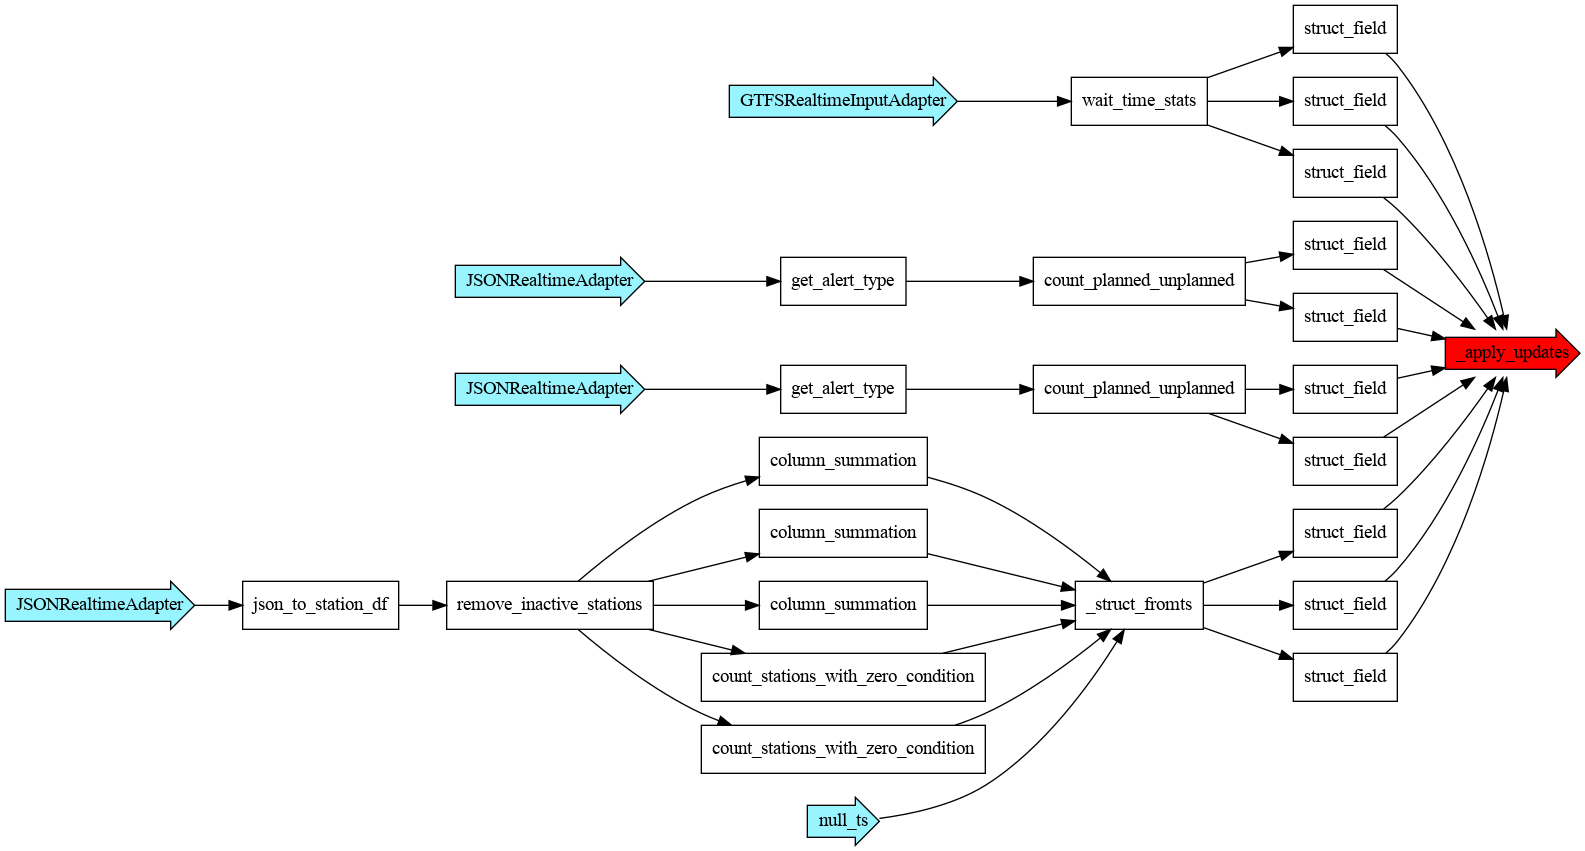

In [26]:
g = table.graph
buffer = csp.showgraph.generate_graph(g)
image = Image.open(buffer)
display(image)

Now let's run our dashboard!

In [24]:
table.start(starttime=datetime.utcnow(), endtime=timedelta(minutes=360), realtime=True, clear=True)
print(table.is_running())

True


In [25]:
w = table.get_widget()
display(w)

PerspectiveWidget(columns=['timestamp', 'subway_avg_wait_time', 'subway_p90_wait_time', 'subway_p99_wait_time'…